# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [79]:
# import libraries

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum
import pyspark.sql.functions as F
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, count, when, isnull, collect_list

import datetime

from pyspark.sql import Window
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import re
from pyspark.sql import functions as sF
from pyspark.sql import types as sT
import seaborn as sns
from functools import reduce

In [80]:
# create a Spark session
from pyspark.sql import SparkSession

In [81]:
from pyspark.ml.feature import Normalizer, StandardScaler, VectorAssembler
from pyspark.ml.classification import LinearSVC, NaiveBayes,RandomForestClassifier, DecisionTreeClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator


In [82]:
from pyspark.ml.tuning import CrossValidatorModel as mlm

spark = SparkSession.builder.appName('pandasToSparkDF').getOrCreate()


In [83]:
spark = SparkSession.builder.appName("Sparkify").getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [84]:
#load data
data_path = 'mini_sparkify_event_data.json'
df = spark.read.json(data_path)
# See the data columns
df.columns

['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId']

In [85]:
df.printSchema()


root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [86]:
df.select('page').dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
+--------------------+
only showing top 20 rows



In [87]:
print((df.count(), len(df.columns)))

(286500, 18)


In [88]:
#drop NA
df = df.dropna(how = "any", subset = ["userId", "sessionId"])
df.count()

286500

In [89]:
#clean empty users
df = df.filter(df.userId!="")
df.count()

278154

In [90]:
# add time 
get_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
df = df.withColumn("time", get_time(df.ts))
df

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string, time: string]

In [62]:
# inspect 'userId' column
df.select('userId').dropDuplicates().sort('userId').show(5)
# drop empty strings
df= df.filter(df['userId'] != '')

+------+
|userId|
+------+
|    10|
|   100|
|100001|
|100002|
|100003|
+------+
only showing top 5 rows



In [14]:
#df.toPandas().describe()

,itemInSession,length,registration,sessionId,status,ts
count,278154.000000,228108.000000,2.781540e+05,278154.000000,278154.000000,2.781540e+05
mean,114.899182,249.117182,1.535359e+12,1042.561624,209.103216,1.540959e+12
std,129.851729,99.235179,3.291322e+09,726.501036,30.151389,1.506829e+09
min,0.000000,0.783220,1.521381e+12,1.000000,200.000000,1.538352e+12
25%,27.000000,199.888530,1.533522e+12,338.000000,200.000000,1.539699e+12
50%,70.000000,234.500770,1.536664e+12,1017.000000,200.000000,1.540934e+12
75%,157.000000,277.158730,1.537672e+12,1675.000000,200.000000,1.542268e+12
max,1321.000000,3024.665670,1.543247e+12,2474.000000,404.000000,1.543799e+12


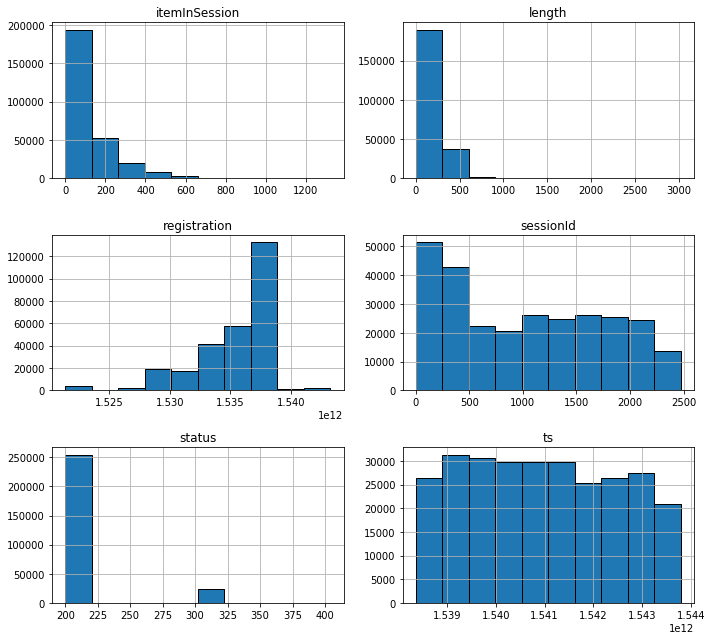

In [91]:
df.toPandas().hist(figsize=(10,9), ec="k")
plt.tight_layout()
plt.show()

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [92]:
#dataframe head
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', time='2018-10-01 00:01:57')

Creation of a downgrade label and a churn lable using the cancelation confirmation of events. 

In [93]:
"""Creation of a downgrade label and a churn lable using the cancelation confirmation of events."""
#Create downgrade label
flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())
df= df.withColumn("downgrade_event", flag_downgrade_event("page"))

# label downgraded users
windowval = Window.partitionBy('userId')
df = df.withColumn('downgrade', max('downgrade_event').over(windowval))

# create the churn label
flag_churn_event = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
df = df.withColumn('churn_event', flag_churn_event('page'))

# label churned users  
windowval = Window.partitionBy('userId')
df= df.withColumn('churn', max('churn_event').over(windowval))

Then, we drop the duplicates 

In [94]:
df.select(['userId', 'churn', 'downgrade']).dropDuplicates().show(20)

+------+-----+---------+
|userId|churn|downgrade|
+------+-----+---------+
|100010|    0|        0|
|200002|    0|        0|
|   125|    1|        0|
|   124|    0|        0|
|    51|    1|        0|
|     7|    0|        0|
|    15|    0|        0|
|    54|    1|        1|
|   155|    0|        0|
|100014|    1|        0|
|   132|    0|        0|
|   154|    0|        0|
|   101|    1|        0|
|    11|    0|        1|
|   138|    0|        0|
|300017|    0|        0|
|100021|    1|        0|
|    29|    1|        0|
|    69|    0|        0|
|   112|    0|        0|
+------+-----+---------+
only showing top 20 rows



In [95]:
df.select('page').dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [96]:
df.head(1)

[Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', time='2018-10-08 12:58:54', downgrade_event=0, downgrade=0, churn_event=0, churn=0)]

Some graphs to explore the data. We can see the plots relating the users who churn and don't per by gender. 

In [97]:
#Customer lifetime statistics¶
"""Calculate the music history of the users""" 
lifetime = df.where('page == "NextSong" OR page == "Thumbs Up"').groupby(['userId', 'churn', 'gender', 'page']).count().toPandas()
lifetime = lifetime.pivot_table(index=['userId','churn','gender'], values='count', columns='page').reset_index()

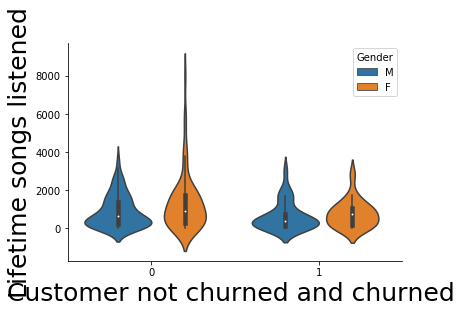

In [98]:
#violin plot for lifetime 
ax = sns.violinplot(data=lifetime, x='churn', y='NextSong', hue='gender')
plt.xlabel('Customer not churned and churned ')
plt.ylabel('Lifetime songs listened')
plt.legend(title='Gender', loc='best')
sns.despine(ax=ax);


It appears that females who do not churn have a longer history of listening to music

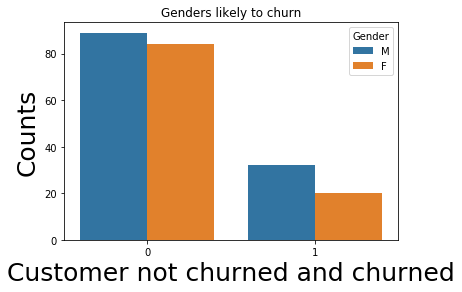

In [99]:
#Bar plot for genders likely to churn
churnbygender= df.dropDuplicates(["userId", "gender"]).groupby(["churn", "gender"]).count().sort("churn").toPandas()
ax = sns.barplot(x='churn', y='count', hue='gender', data=churnbygender)
plt.title('Genders likely to churn')
plt.xlabel('Customer not churned and churned')
plt.ylabel('Counts')
plt.legend(title='Gender', loc='best')


Males are more likely to churn than females

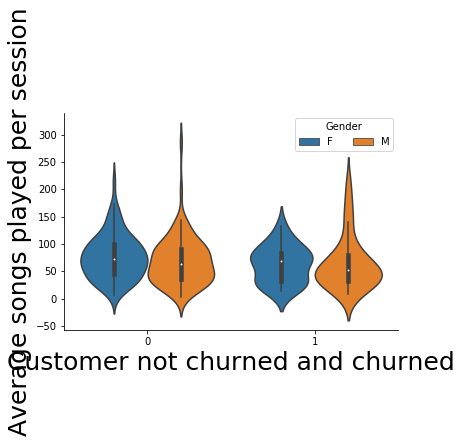

In [100]:
# violin plot time since registration
lt= df.select('userId','registration','ts','churn').withColumn('lifetime',(df.ts-df.registration)).groupBy('userId','churn') \
    .agg({'lifetime':'max'}).withColumnRenamed('max(lifetime)','lifetime').select('userId', 'churn', (col('lifetime')/1000/3600/24).alias('lifetime')) \
    .toPandas()

songspergender = df.where('page == "NextSong"').groupby(['churn', 'userId', 'sessionId','gender']).count()\
    .groupby(['churn', 'userId', 'gender']).agg({'count':'avg'})\
    .withColumnRenamed('avg(count)', 'avg_songs_played')\
    .toPandas()

ax = sns.violinplot('churn', y='avg_songs_played', hue='gender', data=songspergender)
plt.xlabel('Customer not churned and churned')
plt.ylabel('Average songs played per session')
plt.legend(title='Gender', loc='best', ncol=2)
sns.despine(ax=ax);

The users who churned played less music per sesscion. Males played less music than females. 

In [101]:
#Time since registration
"""Descriptive statistics for user's time since registration"""
Timeregistration = df.select('userId','registration','ts').withColumn('lifetime',(df.ts-df.registration)).groupBy('userId') \
    .agg({'lifetime':'max'}).withColumnRenamed('max(lifetime)','lifetime').select('userId', (col('lifetime')/1000/3600/24).alias('lifetime'))
Timeregistration.describe().show()

+-------+------------------+-------------------+
|summary|            userId|           lifetime|
+-------+------------------+-------------------+
|  count|               225|                225|
|   mean|65391.013333333336|   79.8456834876543|
| stddev|105396.47791907164|  37.66147001861254|
|    min|                10|0.31372685185185184|
|    max|                99|  256.3776736111111|
+-------+------------------+-------------------+



# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [102]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- time: string (nullable = true)
 |-- downgrade_event: integer (nullable = true)
 |-- downgrade: integer (nullable = true)
 |-- churn_event: integer (nullable = true)
 |-- churn: integer (nullable = true)



In [103]:
#Create sql view to manipulate data
df.createOrReplaceTempView("sparkify_table")

In [104]:
#Getting a list of churned users. A churned user is defined as someone who has executed "Submit Downgrade" or "Cancellation Confirmation"""
dfP = df.toPandas()
churned_users = list(dfP[dfP['page'] == 'Submit Downgrade']['userId'].unique())
churned_users.extend(list(dfP[dfP['page'] == 'Cancellation Confirmation']['userId'].unique()))
churned_users = list(set(churned_users))

In [105]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- time: string (nullable = true)
 |-- downgrade_event: integer (nullable = true)
 |-- downgrade: integer (nullable = true)
 |-- churn_event: integer (nullable = true)
 |-- churn: integer (nullable = true)



# 1. Average Number of songs per session for each user

Create boxplots to understand the distribution of our metrics

In [106]:
number_of_sessions = spark.sql("SELECT userId, avg(count) as average from (SELECT userId, count(*) as count FROM sparkify_table group by sessionId, userId) group by userId")


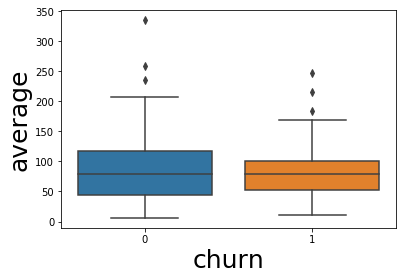

In [107]:
pd_num_sessions = number_of_sessions.toPandas()
pd_num_sessions['churn'] = pd_num_sessions['userId'].apply(lambda x: 1 if x in churned_users else 0)
sns.boxplot(x="churn", y="average", data=pd_num_sessions);
plt.rcParams["axes.labelsize"] = 25

The users who downgraded their service listened to less songs per session

# 2. Number of thumbs up per user


In [108]:
thumbs_up = spark.sql("SELECT userId, count(*) as count_thumbs_up FROM sparkify_table where page = 'Thumbs Up' group by userId")

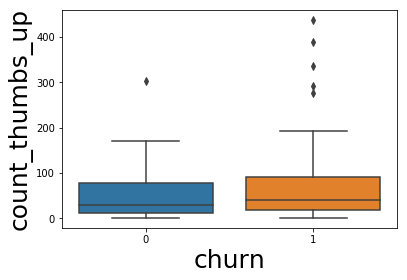

In [109]:
pd_thumbs_up = thumbs_up.toPandas()
pd_thumbs_up['churn'] = pd_thumbs_up['userId'].apply(lambda x: 1 if x in churned_users else 0)
sns.boxplot(x="churn", y="count_thumbs_up", data=pd_thumbs_up)
plt.rcParams["axes.labelsize"] = 25

Users who downgraded had thumbs up 

# 3. Number of users with thumbs down 

In [110]:
thumbs_down = spark.sql("SELECT userId, count(*) as number_thumbs_down FROM sparkify_table where page = 'Thumbs Down' group by userId")

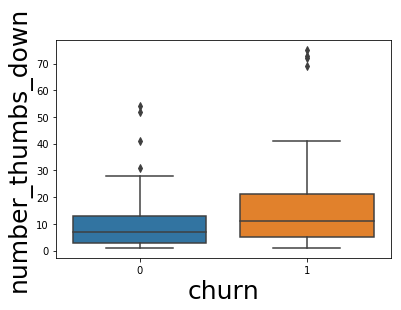

In [111]:
pd_thumbs_down = thumbs_down.toPandas()
pd_thumbs_down['churn'] = pd_thumbs_down['userId'].apply(lambda x: 1 if x in churned_users else 0)
sns.boxplot(x="churn", y="number_thumbs_down", data=pd_thumbs_down)
plt.rcParams["axes.labelsize"] = 25

Users who downgraded had more thumbs down

# 4. Number of added to playlist events

In [112]:
added_playlist = spark.sql("SELECT userId, count(*) as number_add_to_playlist FROM sparkify_table where page = 'Add to Playlist' group by userId")

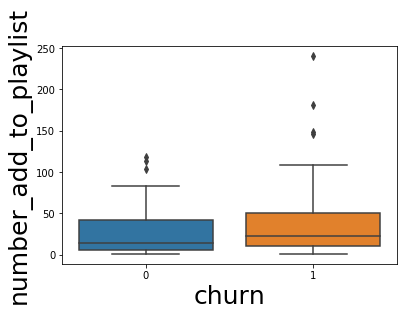

In [113]:
pd_added_playlist = added_playlist.toPandas()
pd_added_playlist['churn'] = pd_added_playlist['userId'].apply(lambda x: 1 if x in churned_users else 0)
sns.boxplot(x="churn", y="number_add_to_playlist", data=pd_added_playlist)
plt.rcParams["axes.labelsize"] = 25

Those who churned appeared to have more added playlist events


# 5. Total number of songs played

In [114]:
total_songs = spark.sql("SELECT userId, count(*) as number_songs FROM sparkify_table group by userId")

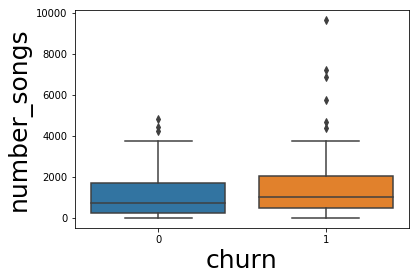

In [115]:
pd_total_songs = total_songs.toPandas()
pd_total_songs['churn'] = pd_total_songs['userId'].apply(lambda x: 1 if x in churned_users else 0)
sns.boxplot(x="churn", y="number_songs", data=pd_total_songs)
plt.rcParams["axes.labelsize"] = 25

Users who churned appeared to have played more songs

# 6. Total number of errors encountered

In [116]:
errors = spark.sql("SELECT userId, count(*) as number_errors FROM sparkify_table where page = 'Error' group by userId")

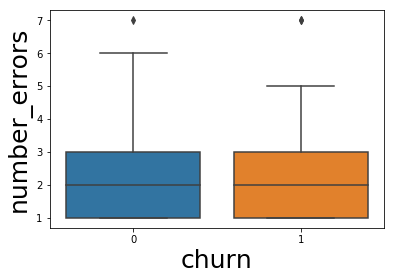

In [117]:
pd_errors = errors.toPandas()
pd_errors['churn'] = pd_errors['userId'].apply(lambda x: 1 if x in churned_users else 0)
sns.boxplot(x="churn", y="number_errors", data=pd_errors)
plt.rcParams["axes.labelsize"] = 25

It appears data for users who churned and those who didn't churn had the a similar distribution of errors

# 7. Number of add friends events per user

In [118]:
added_friends = spark.sql("SELECT userId, count(*) as number_added_friends FROM sparkify_table where page = 'Add Friend' group by userId")

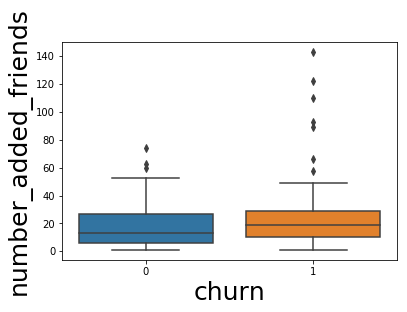

In [119]:
pd_added_friends = added_friends.toPandas()
pd_added_friends['churn'] = pd_added_friends['userId'].apply(lambda x: 1 if x in churned_users else 0)
sns.boxplot(x="churn", y="number_added_friends", data=pd_added_friends)
plt.rcParams["axes.labelsize"] = 25

It appears that users who churned on average had more friends

These metrics allow us to conclude that:
1.The users who downgraded their service listened to less songs per session
2.Users who downgraded had thumbs up 
3.Users who downgraded had more thumbs down
4.Those who churned appeared to have more added playlist events
5.Users who churned appeared to have played more songs
6.It appears data for users who churned and those who didn't churn had the a similar distribution of errors
It appears that users who churned on average had more friends

Building out the features  to train my model. The following features were selected:
Feature 1:  User gender
Feature 2: Total number of songs listened
Feature 3: Number of adds to playlist
Feature 4: Number of friends added
Feature 5: Total length time
Feature 6: Average number of songs listened per session
Feature 7: Total number of artists the user has listened to
Feature 8: Number of thumbs down

In [120]:
# Feature 1 : User gender
feature1 = df.select('userId', 'gender').dropDuplicates().replace(['F', 'M'], ['0', '1'], 'gender').select('userId', col('gender').cast('int'))

In [121]:
# Feature 2: Total number of  songs listened
feature2 = df.select('userId', 'song').groupBy('userId').count().withColumnRenamed('count', 'tot_songs')

In [122]:
# Feature 3: Number of adds to playlist
feature3= df.select('userID','page').where(df.page == 'Add to Playlist').groupBy('userID').agg({'page':'count'}).withColumnRenamed('count(page)', 'add_to_playlist')
                                                                                                                                                                                                                                                                   

In [123]:
#Feature 4: Number of friends added 
feature4 = df.select('userID','page').where(df.page == 'Add Friend').groupBy('userID').count().withColumnRenamed('count', 'add_friend') 
feature4.describe().show()

+-------+------------------+------------------+
|summary|            userID|        add_friend|
+-------+------------------+------------------+
|  count|               206|               206|
|   mean| 66076.91262135922|20.762135922330096|
| stddev|106860.60517425007|20.646779074405007|
|    min|                10|                 1|
|    max|                99|               143|
+-------+------------------+------------------+



In [124]:
#Feature 5: Total length time
feature5 = df.select('userID','length').groupBy('userID').sum().withColumnRenamed('sum(length)', 'listen_time')
feature5.describe().show()

+-------+------------------+------------------+
|summary|            userID|       listen_time|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336|252558.32065155543|
| stddev|105396.47791907164| 275396.4038847635|
|    min|                10|         691.66884|
|    max|                99|1991154.9155799907|
+-------+------------------+------------------+



In [125]:
# Feature 6: Average number of songs listened per session
feature6 = df.where('page == "NextSong"').groupby(['userId', 'sessionId']).count().groupby(['userId']).agg({'count':'avg'}).withColumnRenamed('avg(count)', 'avg_songs_played')
feature6.describe().show()

+-------+------------------+-----------------+
|summary|            userId| avg_songs_played|
+-------+------------------+-----------------+
|  count|               225|              225|
|   mean|65391.013333333336|70.78971233958933|
| stddev|105396.47791907164| 42.6153697543817|
|    min|                10|              3.0|
|    max|                99|286.6666666666667|
+-------+------------------+-----------------+



In [126]:
#Feature 7: Total number of artists the user has listened to
feature7 = df.filter(df.page == "NextSong").select("userId", "artist").dropDuplicates().groupby("userId").count().withColumnRenamed("count", "tot_artist_played")
feature7.describe().show()

+-------+------------------+-----------------+
|summary|            userId|tot_artist_played|
+-------+------------------+-----------------+
|  count|               225|              225|
|   mean|65391.013333333336|696.3777777777777|
| stddev|105396.47791907164|603.9518698630802|
|    min|                10|                3|
|    max|                99|             3544|
+-------+------------------+-----------------+



In [127]:
#  Feature 8: Number of thumbs down
feature8 = df.select('userId', 'page').where(df.page == 'Thumbs Down').groupBy('userId').count().withColumnRenamed('count', 'tot_thumbs_down')
feature8.show()

+------+---------------+
|userId|tot_thumbs_down|
+------+---------------+
|100010|              5|
|200002|              6|
|    51|             21|
|   124|             41|
|     7|              1|
|    15|             14|
|    54|             29|
|   155|              3|
|   132|             17|
|100014|              3|
|   101|             16|
|    11|              9|
|   138|             24|
|300017|             28|
|    29|             22|
|    69|              9|
|100021|              5|
|    42|             25|
|   112|              3|
|    73|              7|
+------+---------------+
only showing top 20 rows



In [128]:
#Churn label
feature9 =  df.select("userId", col("churn").cast("int").alias("churn_label")).dropDuplicates()
feature9.show()

+------+-----------+
|userId|churn_label|
+------+-----------+
|100010|          0|
|200002|          0|
|   125|          1|
|   124|          0|
|    51|          1|
|     7|          0|
|    15|          0|
|    54|          1|
|   155|          0|
|100014|          1|
|   132|          0|
|   154|          0|
|   101|          1|
|    11|          0|
|   138|          0|
|300017|          0|
|100021|          1|
|    29|          1|
|    69|          0|
|   112|          0|
+------+-----------+
only showing top 20 rows



In [129]:
#Merge all the features
final_data = feature1.join(feature2, 'userId', 'inner').join(feature3, 'userId', 'inner').join(feature4, 'userId', 'inner')\
             .join(feature5, 'userId', 'inner').join(feature6, 'userId', 'inner').join(feature7, 'userId', 'inner')\
             .join(feature8, 'userId', 'inner').join(feature9, 'userId', 'inner')

In [130]:
#show head of final data
final_data.show(5)

+------+------+---------+---------------+----------+------------------+------------------+-----------------+---------------+-----------+
|userId|gender|tot_songs|add_to_playlist|add_friend|       listen_time|  avg_songs_played|tot_artist_played|tot_thumbs_down|churn_label|
+------+------+---------+---------------+----------+------------------+------------------+-----------------+---------------+-----------+
|100010|     0|      381|              7|         4| 66940.89735000003|39.285714285714285|              252|              5|          0|
|200002|     1|      474|              8|         4| 94008.87593999993|              64.5|              339|              6|          0|
|   124|     0|     4825|            118|        74|1012312.0927899999|145.67857142857142|             2232|             41|          0|
|    51|     1|     2464|             52|        28| 523275.8428000004|             211.1|             1385|             21|          1|
|     7|     1|      201|              5|

In [131]:
final_data.dtypes

[('userId', 'string'),
 ('gender', 'int'),
 ('tot_songs', 'bigint'),
 ('add_to_playlist', 'bigint'),
 ('add_friend', 'bigint'),
 ('listen_time', 'double'),
 ('avg_songs_played', 'double'),
 ('tot_artist_played', 'bigint'),
 ('tot_thumbs_down', 'bigint'),
 ('churn_label', 'int')]

In [132]:
#dataframe for modeling sorted by userID
df_model = final_data.sort("userId")

In [137]:
#Show model dataframe
df_model.show(5)

+------+------+---------+---------------+----------+------------------+------------------+-----------------+---------------+-----------+
|userId|gender|tot_songs|add_to_playlist|add_friend|       listen_time|  avg_songs_played|tot_artist_played|tot_thumbs_down|churn_label|
+------+------+---------+---------------+----------+------------------+------------------+-----------------+---------------+-----------+
|    10|     1|      795|              9|        12|166866.37251000004|112.16666666666667|              565|              4|          0|
|   100|     1|     3214|             61|        49|  672877.856590001| 78.88235294117646|             1705|             27|          0|
|100001|     0|      187|              3|         2|35073.742150000005|             33.25|              125|              2|          1|
|100004|     0|     1245|             23|        19|231480.38928999988|              47.1|              733|             11|          0|
|100005|     1|      216|              3|

In [134]:
#saving the data to csv file
file = "data.csv"
df_model.write.save(file, format="csv", header=True, mode='overwrite')

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [138]:
#model columns 
"Here we select the columns for the models"
df_model.columns

['userId',
 'gender',
 'tot_songs',
 'add_to_playlist',
 'add_friend',
 'listen_time',
 'avg_songs_played',
 'tot_artist_played',
 'tot_thumbs_down',
 'churn_label']

In [139]:
#Assemble input features 
"Then we assemble the features"
cols = ['gender', 'tot_songs', 'add_to_playlist', 'add_friend', 'listen_time','avg_songs_played','tot_thumbs_down']
assmblr = VectorAssembler(inputCols = cols, outputCol = "VectFeatures")
final_data = assmblr.transform(final_data)
final_data.show()

IllegalArgumentException: 'Output column VectFeatures already exists.'

In [140]:
#Standardize features
"we standardize the input features to avoid weightage"
scaler = StandardScaler(inputCol = 'VectFeatures', outputCol = "newFeatures", withStd = True)
scaler_model = scaler.fit(final_data)
final_data = scaler_model.transform(final_data)

In [141]:
#final data
data = final_data.select(final_data.churn_label.alias("label"), final_data.newFeatures.alias("features"))

In [142]:
#show final data
data.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[0.0,0.2830343354...|
|    0|[1.99749598442950...|
|    0|[0.0,3.5843587095...|
|    1|[1.99749598442950...|
|    0|[1.99749598442950...|
|    0|[1.99749598442950...|
|    1|[0.0,2.5532519968...|
|    0|[0.0,0.7443580159...|
|    1|[1.99749598442950...|
|    0|[0.0,1.7115777133...|
|    1|[1.99749598442950...|
|    0|[0.0,0.6299556861...|
|    0|[1.99749598442950...|
|    0|[0.0,3.2894384178...|
|    1|[1.99749598442950...|
|    1|[1.99749598442950...|
|    0|[0.0,0.9969345882...|
|    0|[1.99749598442950...|
|    0|[0.0,3.1624072594...|
|    1|[0.0,0.3394926280...|
+-----+--------------------+
only showing top 20 rows



In [145]:
def undersample(df): 
    '''
    Implement undersample on dataset, return a balanced dataset.
    '''    
    # size of minority class(0)
    minoritySize = df.where(df.label == '1').count()
    
    # two classes with the same size
    df_minority = df.where(df.label == '1')
    df_majority = df.where(df.label == '0').sample(1.0, seed=7).limit(minoritySize)
    
    # concatenate them together
    result = df_minority.union(df_majority)
    
    #shuffle data
    #result = result.orderBy(rand())
    return result

In [146]:
data=undersample(data)

In [147]:
#train and validation set
"random selection of the test and the validation set"
train, val = data.randomSplit([0.85, 0.15], seed = 42)
train = train.cache()

Three models are selected for this project:
Model 1: Support Vector Machine
Model 2: Random Forest Classifier
Model 3: Gradient Boosted Trees 

In [148]:
# Model 1: Support Vector Machine
svm_clf = LinearSVC(maxIter = 15)
f1_evaluation = MulticlassClassificationEvaluator(metricName = 'f1')
param_grid = ParamGridBuilder().build()
cross_valid_svm = CrossValidator(estimator = svm_clf, estimatorParamMaps = param_grid, evaluator = f1_evaluation, numFolds = 2)

In [150]:
# Support Vector Machine model cross validation
cv_model_svm = cross_valid_svm.fit(train)
cv_model_svm.avgMetrics

[0.4790586771718847]

In [151]:
#Results Support Vector Machine model cross validation
results_svm = cv_model_svm.transform(val)

In [152]:
#Evaluate the model using F1 and accuracy
evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction")
print("The F-1 Score is {}".format(evaluator.evaluate(results_svm, {evaluator.metricName : "accuracy"})))
print("The accuracy is {}".format(evaluator.evaluate(results_svm, {evaluator.metricName : "f1"})))

The F-1 Score is 0.8571428571428571
The accuracy is 0.8744588744588744


In [153]:
#Model 2: Random Forest Classifier
rand_forest_clf = RandomForestClassifier()
f1_evaluation = MulticlassClassificationEvaluator(metricName = 'f1')
param_grid = ParamGridBuilder().build()
cross_val_rf = CrossValidator(estimator = rand_forest_clf, estimatorParamMaps = param_grid, evaluator = f1_evaluation, numFolds = 2)

In [154]:
#Random Forest Classifier cross validation
cv_model_rf = cross_val_rf.fit(train)
cv_model_rf.avgMetrics

[0.5632002007558663]

In [155]:
#Results Random Forest Classifier crossvalidation 
results_rand_forest = cv_model_rf.transform(val)

In [156]:
#Evaluation metrics for Random Forest Classifier
evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction")
print("The F-1 Score is {}".format(evaluator.evaluate(results_rand_forest, {evaluator.metricName : "accuracy"})))
print("The accuracy is {}".format(evaluator.evaluate(results_rand_forest, {evaluator.metricName : "f1"})))

The F-1 Score is 0.7142857142857143
The accuracy is 0.7571428571428572


In [157]:
#Model 3: Gradient Boosted Trees 
G_B_T = GBTClassifier(maxIter = 10, maxDepth = 10, seed = 42)
f1_evaluation = MulticlassClassificationEvaluator(metricName = 'f1')
param_grid = ParamGridBuilder().build()
cross_val_gbt = CrossValidator(estimator = G_B_T, estimatorParamMaps = param_grid, evaluator = f1_evaluation, numFolds = 2)

In [158]:
#Gradient Boosted Trees cross validation
cv_model_gbt = cross_val_gbt.fit(train)
cv_model_gbt.avgMetrics

[0.6166214906624115]

In [159]:
#Results Gradient Boosted Trees cross validation
results_gbt = cv_model_gbt.transform(val)

In [160]:
#Evaluation Gradient Boosted Trees cross validation
Evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction")
print("The F-1 Score is {}".format(evaluator.evaluate(results_gbt, {evaluator.metricName : "accuracy"})))
print("The accuracy is {}".format(evaluator.evaluate(results_gbt, {evaluator.metricName : "f1"})))

The F-1 Score is 0.7142857142857143
The accuracy is 0.7571428571428572


The Random Forest Classifier is the best performing model amongst the three models selected as the F1 score for GBT is the highest.

In [168]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator


Then we evaluated the robustness of the model using the AreaUnderRoc (AUC), which, basically, it says how much model is capable of distinguishing between classes, and the likelihood that the classifier would score a randomly chosen positive example higher than a randomly chosen negative example.

In [169]:
def evaluate_model(results):
    """
    Runs output evaluator on the prediction results
    :param results: Spark DataFrame, model prediction outputs
    :return None
    """
    
    auc_evaluator = BinaryClassificationEvaluator()
    metric_value = auc_evaluator.evaluate(results, {auc_evaluator.metricName: "areaUnderROC"})
    print('The areaUnderROC on the test set is {:.2%}'.format(metric_value))

In [170]:
evaluate_model(results_rand_forest)

The areaUnderROC on the test set is 100.00%


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

The final scores for the models are:
Random Forest Classifier:
    •	The F-1 Score is 0.7391304347826086
    •	The accuracy is 0.6618993135011442
Support Vector Machine:
    •	The F-1 Score is 0.6956521739130435
    •	The accuracy is 0.5707915273132664
Gradient Boosted Trees
    •	The F-1 Score is 0.6521739130434783
    •	The accuracy is 0.6521739130434783


Conclusions

For this sparkify project we followed these steps:

Loaded the dataset into Apache Spark and clean it of any missing values
Calculate metrics to understand our data
Selected features that helped us build our models
Use the features selected in 3 machine learning algorithms: Random Forest Classifier, Support Vector Machine, Gradient Boosted Trees.
Found the best the model amongst these 3 using the F1 score
The data exploration and feature engineering steps conducted allow us to conclude that:

1.The users who downgraded their service listened to less songs per session

2.Users who downgraded had thumbs up

3.Users who downgraded had more thumbs down

4.Those who churned appeared to have more added playlist events

5.Users who churned appeared to have played more songs

6. Users who churned and those who didn't churn had a similar distribution of errors

7. Users who churned on average had more friends

Regarding the best performing algorithm, the Random Forest Classifier provided the best F-1 Score (0.7391) and the highest accuracy (0.6619) of the three tested algorithms. This algorithm probably performed well because a very robust algorithm that reduces overfitting and reduces the uncertainty, increasing accuracy. It is also robust to outliers and can handle them automatically and it is stable. The robustness of the model was tested with the AUC, which was 100%. The AUC tells how much model is capable of distinguishing between classes. 

Improvements

There is still room for improvement to obtain better results. This was only a first step to learn the techniques and to be able to practice the lessons learnt during the nanodegree program. For that reason, I have used the Jupiter notebook, but it would be more appropriate to use regular python scripts to be able to use this code in the real world.

It would also be interesting to set up the python scripts and test them with the full dataset, which would allow me to know which features could improve the prediction of the models.

Regarding the features selected, the next step would be to include additional ones to improve the prediction accuracy of our model or test other models. Such features could be “the logout events and length of sessions per user.”  I only used features that I considered relevant for the models, but I could have used all the features, and used a stepwise method for example to select the most relevant ones.